# RELIKE - Reionization Effective Likelihood 

## Example 1. Comparing The Likelihood Ratio of Tanh Models 

### 1. Create a PC object which contains all PC related operations. 

Create a PC object using `relike.PC()`. The ionization fraction can be fully described as $x_e(z) = x_e^{\rm fid}(z) + \sum_{j=1}^{n_{\rm PC}} m_j S_j(z)$ with all $n_{\rm PC} = 95$ PCs, but only $n_{\rm PC} = 5$ are needed to describe within cosmic variance, the observational impact of any model between $6 < z < 30$ on the low-$\ell$ CMB polarization power spectrum $C_l^{EE}$. To plot out the first 5 PC functions $S_j(z)$ and the fiducial model, use `pc.plot_pc()`.

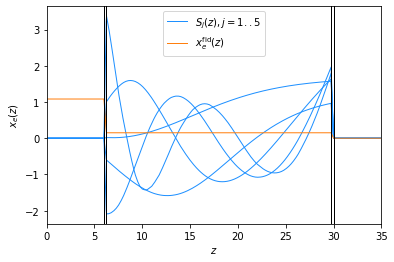

In [2]:
import relike
pc = relike.PC()
pc.plot_pc()

### 2. Create a tanh model function with $z_{\rm re} = 10.0$, and get its PC amplitudes $m_j$'s. 

In [5]:
tanh_model = relike.TanhModel()
xe_func = tanh_model.get_xe_func(zre=10.0, no_helium=True) 

mjs = pc.get_mjs(xe_func)
print('mjs = {}'.format(mjs))

mjs = [-0.11712834 -0.09884358  0.21770627 -0.22767822  0.1037556 ]


We have set **`no_helium=True`** to not include the second helium ionization for the purpose of PC projections, since the fiducial model $x_e^{\rm fid}(z)$ already includes it.

### 3. Obtain the effective likelihood of the model. 
This python package supports the Gaussian likelihood mode only , which was shown to be good enough for typical models in Heinrich & Hu 2021 [add arxiv number]. 
Note: The kernel density estimate (KDE) mode is not supported here, but is available in our CosmoMC implementation in Fortran.

In [6]:
gauss_like = relike.GaussianLikelihood()
loglike = gauss_like.get_loglike(mjs)
print('loglike = {}'.format(loglike))

loglike = -5.360980709970866


### 4. Compare the likelihood ratio against the Planck 2018 best-fit tanh model

Create a model with zre = 8.1 (best-fit from `plik_TTTEEE+lowl+sroll2` likelihood combination) [revise number] and get its PC projection.

In [7]:
xe_func_bf = tanh_model.get_xe_func(zre=8.1, no_helium=True)
mjs_bf = pc.get_mjs(xe_func_bf)

Compare delta chi-squared between the two models:

In [8]:
loglike_bf = gauss_like.get_loglike(mjs_bf)
delta_chi_squared = -2.0 * (loglike - loglike_bf)
print('delta_chi_squared', delta_chi_squared)

delta_chi_squared 9.805612607400667


Indeed the $z_{\rm re} = 10.0$ is a worse model than $z_{\rm re} = 8.1$ in the Planck 2018 data.

## Example 2. Plot posterior for an 1-parameter model 

### 1. Obtain likelihoods for a list of tau values

In [11]:
import numpy as np

pc = relike.PC()
use_fiducial_cosmology = True
gauss_like = relike.GaussianLikelihood()

zre_values = np.linspace(6.1, 10.5, 101)
tau_values = np.zeros_like(zre_values)
likelihood = np.zeros_like(zre_values)

for i, zre in enumerate(zre_values):
    tanh_model = relike.TanhModel()
    xe_func = tanh_model.get_xe_func(zre=zre, no_helium=True)
    mjs = pc.get_mjs(xe_func)
    use_fiducial_cosmology = True
    tau_values[i] = pc.get_tau(mjs, use_fiducial_cosmology)
    likelihood[i] = np.exp(gauss_like.get_loglike(mjs))

### 2. Assuming flat prior in $\tau$, plot its posterior

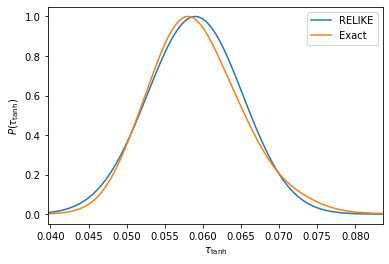

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tau_values, likelihood/np.max(likelihood), label = 'RELIKE')
ax.set_xlabel(r'$\tau_{\rm tanh}$')
ax.set_ylabel(r'$P(\tau_{\rm tanh})$')
ax.set_xlim([tau_values[0], tau_values[-1]])

import os
example_dir = os.getcwd()
fn = 'tau_posterior_pl18_tanh_pliklite_srollv2_dz_auto.dat'
fn = os.path.join(example_dir, 'data/', fn)
data = np.genfromtxt(fn)
ax.plot(data[:,0], data[:,1], label = 'Exact')

ax.legend()